In [1]:
import numpy as np
import pandas as pd
from radioReduction import *
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.optimize as op
import random
import emcee
import corner


In [2]:
'''
Importing the data and binning every 10 seconds
'''
dt = pd.read_table('1314/dataTables/2M1314e18-LLRR.dat')
binned = binning(dt,sec=10,binning=2)

def binPlot(Type='minutes'):
    if Type == 'minutes':
        plt.errorbar(binned['dtmin'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['dtmin'],binned['re'],color='black',label='Data')
    else:
        plt.errorbar(binned['secs'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['secs'],binned['re'],color='black',label='Data') 

/home/russell/projects/radio_project/radioReduction.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['secs'] = data['dtmin']*60


In [3]:
'''
Defining our model, likelihoood, and prior functions
'''
def linearModel(theta,x):
    '''
    Linear model fitting to the data
    '''
    m,b = theta
    y = m*x+b
    return y

def lnprior(theta):
    '''
    Uniform priors for m and b constrained by the data
    '''
    m,b = theta
    if -1 < m < .5 and 1.0 < b < 1.5:
        return 0.0
    return -np.inf

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-linearModel(theta,x))**2/yerr**2))

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [4]:
# Putting data to variables
x = binned['dtmin']
y = binned['re']
yerr = binned['ure']

In [34]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
nll = lambda *args: -lnlike(*args)
x0 = [5,3]
linearResult = op.minimize(nll,x0,args=(x,y,yerr))
m_ml,b_ml = linearResult.x
print(m_ml,b_ml)


-0.012706005613407186 1.1956474109862107


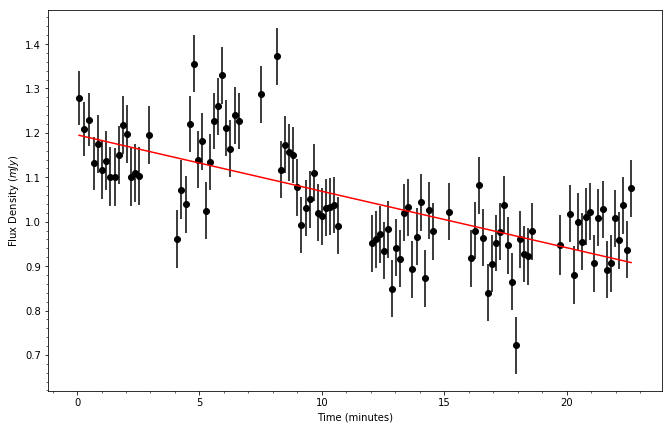

In [35]:
# Plotting results from maximized likelihood
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
plt.plot(x,linearModel([m_ml,b_ml],x),color='red',label='Linear Model')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e18_linearModel.png')
plt.show()

In [36]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 2,100

# Initial position somewhere close to the maximum likelihood result
p0 = [linearResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
linearSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = linearSampler.run_mcmc(p0,500)

# Running MCMC
linearSampler.run_mcmc(pos,5000)

(array([[-0.01184467,  1.18141041],
        [-0.01452127,  1.20965197],
        [-0.01278551,  1.19508154],
        [-0.01398678,  1.21283656],
        [-0.01417066,  1.20604781],
        [-0.01297728,  1.20270385],
        [-0.01279858,  1.18576245],
        [-0.0129038 ,  1.20292359],
        [-0.01138077,  1.18358945],
        [-0.01156144,  1.18379977],
        [-0.01280264,  1.20816444],
        [-0.0118291 ,  1.19169794],
        [-0.01279937,  1.18442037],
        [-0.01262715,  1.18426911],
        [-0.01268599,  1.19932924],
        [-0.01292882,  1.19225945],
        [-0.01326631,  1.20735165],
        [-0.01339471,  1.20656444],
        [-0.01301663,  1.19367013],
        [-0.01407905,  1.2093685 ],
        [-0.01189183,  1.18281728],
        [-0.01317116,  1.19612256],
        [-0.01339088,  1.20204808],
        [-0.0116889 ,  1.19093314],
        [-0.01167641,  1.18727979],
        [-0.01312381,  1.19858175],
        [-0.01274853,  1.20130508],
        [-0.01340028,  1.204

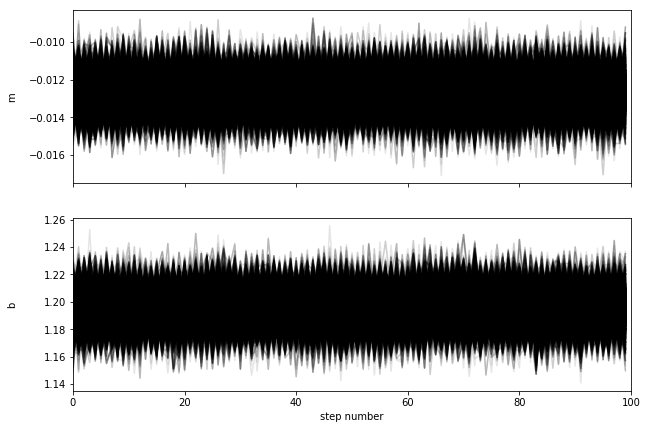

In [11]:
# Plotting the chains
fig, axes = plt.subplots(2,figsize=(10,7),sharex=True)
linearSamples = linearSampler.chain
labels = ['m','b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(linearSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(linearSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e18_linearTrace.png')
plt.show()

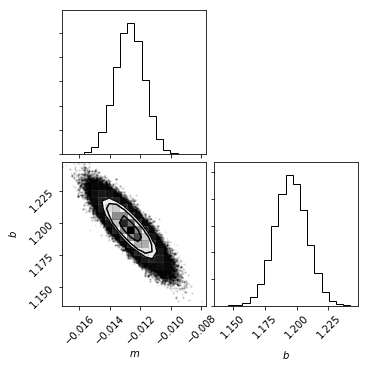

In [37]:
# Flattening the sampler
linearFlat = linearSampler.chain[:,:,:].reshape((-1,ndim))

fig = corner.corner(linearFlat,labels=['$m$','$b$'])
plt.savefig('plots/1314e18_linearCorner.png')
plt.show()

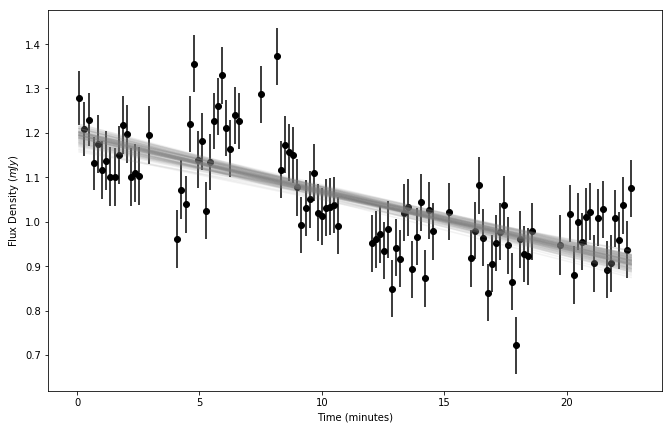

In [13]:
# Plotting first few MCMC steps on the data
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
for m,b in linearFlat[np.random.randint(len(linearFlat),size=100)]:
    plt.plot(binned['dtmin'],m*binned['dtmin']+b,color='gray',alpha=0.1)
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314e18_500mcmc_data.png')
plt.show()

In [38]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(linearFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

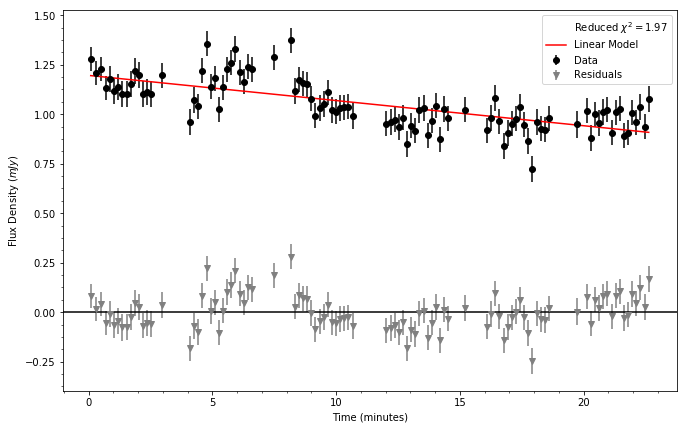

In [40]:
# Getting the 50th percentile of each parameter
linearParameters = []

for i in range(ndim):
    linearParameters.append(np.percentile(linearFlat[:,i],50))
linearParameters = np.array(linearParameters)

# Making model line
linear_model = linearModel(linearParameters,x)

# Residuals
linear_resid = y - linear_model

# Plotting the 50th percentile against the data along with residuals
plt.figure(figsize=(11,7))
plt.plot([], [], ' ', label="Reduced $\chi^2 = 1.97$")
plt.errorbar(x,y,yerr=yerr,color='black',fmt='o',linestyle='None',label='Data')
plt.plot(x,linear_model,color='red',label='Linear Model')
plt.errorbar(x,linear_resid,yerr=yerr,color='gray',fmt='v',linestyle='None',label='Residuals')
plt.axhline(y=0,color='black')
plt.legend(loc='best')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e18_linearModel_fit.png')
plt.show()

In [39]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-linearModel(theta,x))/yerr))
chiSquare(linearParameters,y,yerr)/(len(y)-2)

1.970815145348636

## Looking at logistic function

In [5]:
def logModel(theta,x):
    '''
    Logistic model w/ added term y0 to translate it up
    '''
    l,k,x0,y0 = theta
    denom = 1+np.exp(-k*(x-x0))
    return y0+l/denom

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-logModel(theta,x))**2/yerr**2))

def lnprior(theta):
    '''
    Uniform priors for a and b constrained by the data
    '''
    l,k,x0,y0 = theta
    if -2.5 < l < 1 and -3 < k < 10 and 5 < x0 < 15 and 1.0 < y0 < 1.5:
        return 0.0
    return -np.inf

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [18]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
x = binned['dtmin']
nll = lambda *args: -lnlike(*args)
p0 = [2,6,10,1]
logResult = op.minimize(nll,p0,args=(x,y,yerr))
l_ml,k_ml,x0_ml,y0_ml = logResult.x

print(l_ml,k_ml,x0_ml,y0_ml)

-0.2157907923954625 1.9532759693976691 9.484231324652702 1.1758778148642979


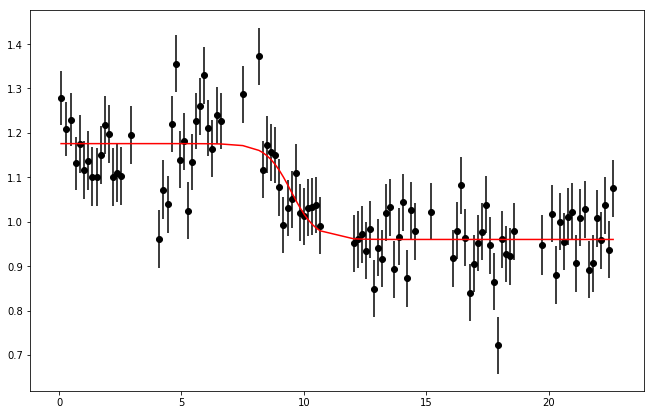

In [19]:
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
plt.plot(x,logModel([l_ml,k_ml,x0_ml,y0_ml],x),color='red')
plt.show()

In [20]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 4,100

# Initial position somewhere close to the maximum likelihood result
p0 = [logResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
logSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = logSampler.run_mcmc(p0,500)
logSampler.reset()

# Running MCMC
logSampler.run_mcmc(pos,5000)

(array([[-0.20213195,  3.01559576,  9.49102208,  1.16116815],
        [-0.20900467,  3.28503766,  9.55149611,  1.16639939],
        [-0.18640131,  9.32539332,  8.8572745 ,  1.15266075],
        [-0.21265627,  2.5694156 ,  9.54672023,  1.17161858],
        [-0.20487263,  5.01955603,  9.72962458,  1.17038693],
        [-0.2406148 ,  3.74576345,  9.0607601 ,  1.19059011],
        [-0.20616742,  2.87430074,  9.31482532,  1.18414336],
        [-0.20582277,  5.85580891,  9.33121416,  1.18071412],
        [-0.1915647 ,  1.61577669,  9.69685001,  1.15536007],
        [-0.21142383,  5.99584264,  9.37497555,  1.17398394],
        [-0.16891468,  2.60658517,  9.58122004,  1.14534999],
        [-0.19741443,  3.66117889,  9.6858826 ,  1.16205931],
        [-0.23763861,  2.66592471,  9.38704953,  1.18256657],
        [-0.20623242,  1.84603331,  9.51601878,  1.15737597],
        [-0.21302721,  2.99588684,  9.34064887,  1.17831118],
        [-0.21744391,  1.88292834,  9.37291267,  1.17165232],
        

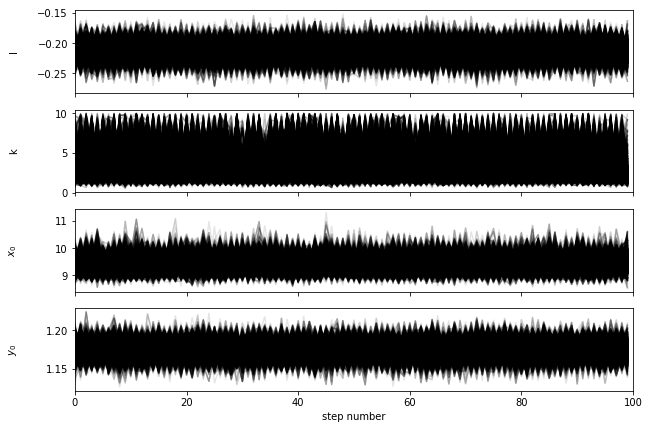

In [21]:
# Plotting the chains
fig, axes = plt.subplots(4,figsize=(10,7),sharex=True)
logSamples = logSampler.chain
labels = ['l','k','$x_0$','$y_0$']
for i in range(4):
    ax = axes[i]
    ax.plot(logSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(logSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('1314e18_Trace.png')
plt.show()

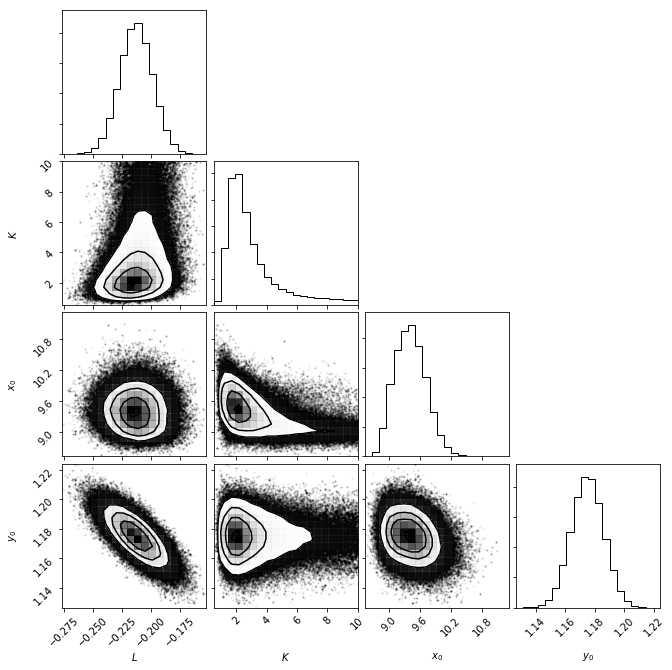

In [22]:
# Flattening the sampler
logFlat = logSampler.chain[:,:,:].reshape((-1,4))
fig = corner.corner(logFlat,labels=['$L$','$K$','$x_0$','$y_0$'])
plt.savefig('plots/e18_logCorner.png')
plt.show()

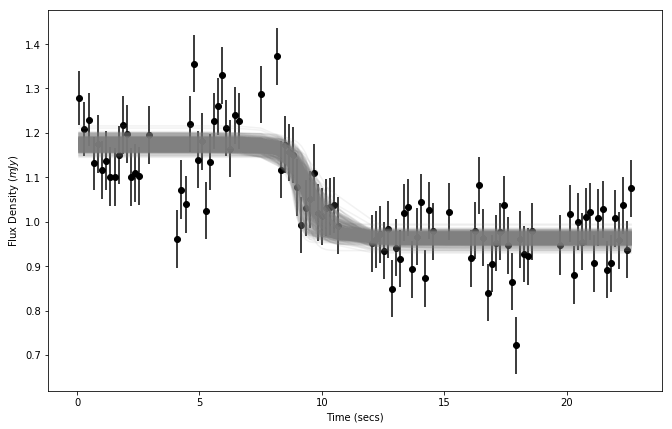

In [23]:
# Plotting first few MCMC steps on the data
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
for l,k,x0,y0 in logFlat[np.random.randint(len(logFlat),size=500)]:
    plt.plot(x,logModel([l,k,x0,y0],x),color='gray',alpha=0.1)
plt.xlabel('Time (secs)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/e18_500mcmc_log.png')
plt.show()

In [24]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(4):
    mcmc = np.percentile(logFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

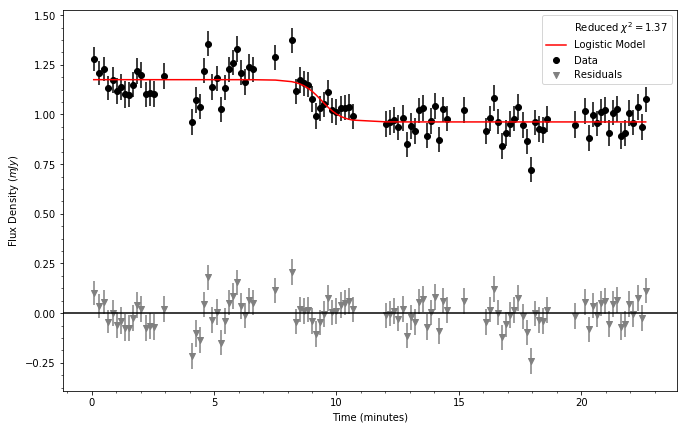

In [29]:
# Getting the 50th percentile of each parameter
logParameters = []

for i in range(4):
    logParameters.append(np.percentile(logFlat[:,i],50))
logParameters = np.array(logParameters)

# Making logistic model
log_model = logModel(logParameters,x)

# Calculating residuals
logResid = y - log_model

# Plotting against the data
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
plt.plot([],[],' ',label='Reduced $\chi^2 = 1.37$')
plt.plot(x,log_model,color='red',label='Logistic Model')
plt.scatter(x,logResid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,logResid,yerr=yerr,color='gray',label='_nolegend_',linestyle='None')
plt.axhline(y=0,color='black')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.minorticks_on()
plt.savefig('plots/e18_logModel.png')
plt.show()

In [27]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-logModel(theta,x))/yerr))
chiSquare(logParameters,y,yerr)/(len(y)-4)

1.3729046587449725

In [2]:
rr = pd.read_table('1314/dataTables/2M1314e18-RR.dat')
ll = pd.read_table('1314/dataTables/2M1314e18-LL.dat')

rr = binning(rr,10,2)
ll = binning(ll,10,2)
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
frac = stV/stI
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['dtmin']

/home/russell/projects/radio_project/radioReduction.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['secs'] = data['dtmin']*60


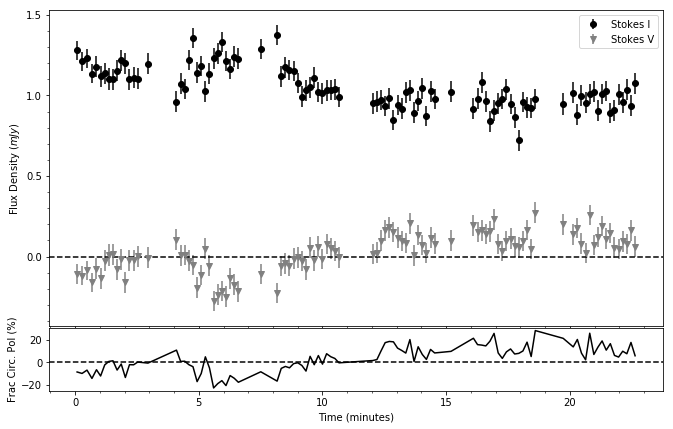

In [3]:
fig,ax = plt.subplots(figsize=(11,7),nrows=2,ncols=1,sharex=True,gridspec_kw = {'hspace':.01,'height_ratios':[5,1]})
ax[0].errorbar(time,stI,yerr=stErr,color='k',linestyle='None',label='Stokes I',fmt='o')
ax[0].errorbar(time,stV,yerr=stErr,color='gray',linestyle='None',label='Stokes V',fmt='v')
ax[0].axhline(y=0,color='k',linestyle='dashed')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].locator_params(axis='y',nbins=4)
ax[0].minorticks_on()

ax[1].plot(time,100*frac,color='k')
ax[1].axhline(y=0,color='k',linestyle='dashed')
ax[1].set_ylabel('Frac Circ. Pol (%)')

plt.xlabel('Time (minutes)')
plt.show()

In [10]:
'''
Calculating the average Stokes V value in quiescent and active emission states
'''

stokes = (stI,stV,time,stErr)
activeV = stokes[1][stokes[2]<9.400]
activeErr = stokes[3][stokes[2]<9.400]
activeErr = 1/np.sqrt(np.sum(1/np.square(activeErr)))

quieV = stokes[1][stokes[2]>9.40]
quieErr = stokes[3][stokes[2]>9.40]
quieErr = 1/np.sqrt(np.sum(1/np.square(quieErr)))



print(np.average(activeV),activeErr,np.average(quieV),quieErr)

-0.0827722566363779 0.00998613478320251 0.1027276837843498 0.008427308918321571


In [11]:
high = pd.read_table('1314/dataTables/2M1314e18-7GHz.dat')
low = pd.read_table('1314/dataTables/2M1314e18-5GHz.dat')

high = high[high['nsamp']>3000]
low = low[low['nsamp']>3000]

high = binning(high,10,2)
low = binning(low,10,2)


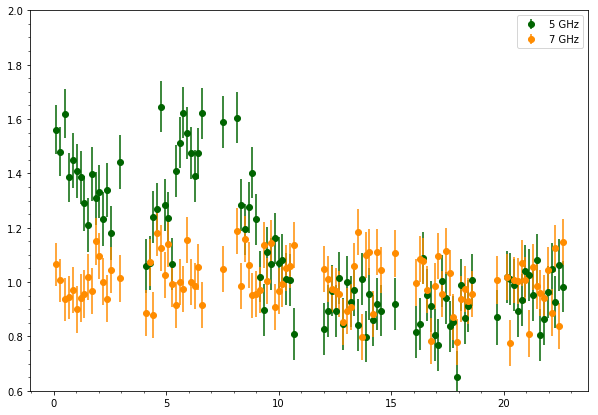

In [12]:
plt.figure(figsize=(10,7))
plt.errorbar(low['dtmin'],low['re'],yerr=low['ure'],marker='o',linestyle='None',color='darkgreen',label='5 GHz')
plt.errorbar(high['dtmin'],high['re'],yerr=high['ure'],marker='o',linestyle='None',color='darkorange',label='7 GHz')
plt.minorticks_on()
plt.legend(loc='best')
plt.ylim(0.6,2.0)

plt.savefig('plots/1314_e18_SED.png')
plt.show()